The steps are broadly
1. Read and understand  the data
2. Clean the data
3. prepare the data for modelling
4.Modelling
5.Final analysis and reco

# 1.Read and visualise the data

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from random import sample
from numpy.random import uniform
from math import isnan

In [82]:
retail_df=pd.read_csv("/content/Online+Retail.csv",sep=",",encoding="ISO-8859-1",header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [83]:
# basics of the df
retail_df.shape

(358336, 8)

In [84]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358336 entries, 0 to 358335
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    358336 non-null  object 
 1   StockCode    358336 non-null  object 
 2   Description  357095 non-null  object 
 3   Quantity     358335 non-null  float64
 4   InvoiceDate  358335 non-null  object 
 5   UnitPrice    358335 non-null  float64
 6   CustomerID   262109 non-null  float64
 7   Country      358335 non-null  object 
dtypes: float64(3), object(5)
memory usage: 21.9+ MB


# 2. Clean the data

In [85]:
# missing values
round(100*(retail_df.isnull().sum())/len(retail_df),2)

InvoiceNo       0.00
StockCode       0.00
Description     0.35
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     26.85
Country         0.00
dtype: float64

In [86]:
# drop all rows having missin g value
retail_df=retail_df.dropna()
retail_df.shape

(262109, 8)

In [87]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [88]:
# new column : amount
retail_df['amount']=retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

<ipython-input-88-5905067ea83e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df['amount']=retail_df['Quantity']*retail_df['UnitPrice']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


 # 3.Prepare the data for modelling

- R (Recency) : Numner of days since last purchase
- F (Frequecy) : Number of transactions
- M (Monetary) : Total amount of transactions (revenue contributed)

In [89]:
#monetary
grouped_df=retail_df.groupby('CustomerID') ['amount'].sum()
grouped_df=grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,2790.86
2,12348.0,1487.24
3,12350.0,334.40
4,12352.0,967.43


In [90]:
# frequency
frequency=retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency=frequency.reset_index()
frequency.columns=['CustomerID','frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,124
2,12348.0,28
3,12350.0,17
4,12352.0,66


In [91]:
# merge the two df
grouped_df=pd.merge(grouped_df,frequency,on='CustomerID',how='inner')

grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,2790.86,124
2,12348.0,1487.24,28
3,12350.0,334.40,17
4,12352.0,967.43,66


In [92]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262109 entries, 0 to 358334
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    262109 non-null  object 
 1   StockCode    262109 non-null  object 
 2   Description  262109 non-null  object 
 3   Quantity     262109 non-null  float64
 4   InvoiceDate  262109 non-null  object 
 5   UnitPrice    262109 non-null  float64
 6   CustomerID   262109 non-null  float64
 7   Country      262109 non-null  object 
 8   amount       262109 non-null  float64
dtypes: float64(4), object(5)
memory usage: 20.0+ MB


In [93]:
#recency
#convert to datetime
retail_df['InvoiceDate']=pd.to_datetime(retail_df['InvoiceDate'],format='%d-%m-%Y %H:%M')
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 262109 entries, 0 to 358334
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    262109 non-null  object        
 1   StockCode    262109 non-null  object        
 2   Description  262109 non-null  object        
 3   Quantity     262109 non-null  float64       
 4   InvoiceDate  262109 non-null  datetime64[ns]
 5   UnitPrice    262109 non-null  float64       
 6   CustomerID   262109 non-null  float64       
 7   Country      262109 non-null  object        
 8   amount       262109 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 20.0+ MB


In [94]:
#compute the max date
max_date=max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-09-25 11:22:00')

In [95]:
#compute the diff
retail_df['diff']=max_date-retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,298 days 02:56:00
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,298 days 02:56:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,298 days 02:56:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,298 days 02:56:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,298 days 02:56:00


In [96]:
# recency
last_purchase=retail_df.groupby('CustomerID') ['diff'].min()
last_purchase=last_purchase.reset_index()
last_purchase

,CustomerID,diff
0,12346.0,250 days 01:05:00
1,12347.0,54 days 02:34:00
2,12348.0,173 days 00:35:00
3,12350.0,234 days 19:21:00
4,12352.0,4 days 20:48:00
...,...,...
3568,18280.0,202 days 01:30:00
3569,18281.0,105 days 00:29:00
3570,18282.0,46 days 20:12:00
3571,18283.0,19 days 22:47:00


In [97]:
# merge the two df
grouped_df=pd.merge(grouped_df,last_purchase,on='CustomerID',how='inner')
grouped_df.columns=['CustomerID', 'amount', 'frequency','recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,250 days 01:05:00
1,12347.0,2790.86,124,54 days 02:34:00
2,12348.0,1487.24,28,173 days 00:35:00
3,12350.0,334.40,17,234 days 19:21:00
4,12352.0,967.43,66,4 days 20:48:00


In [98]:
#number of days only
grouped_df['recency']=grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,250
1,12347.0,2790.86,124,54
2,12348.0,1487.24,28,173
3,12350.0,334.40,17,234
4,12352.0,967.43,66,4


<Axes: ylabel='amount'>

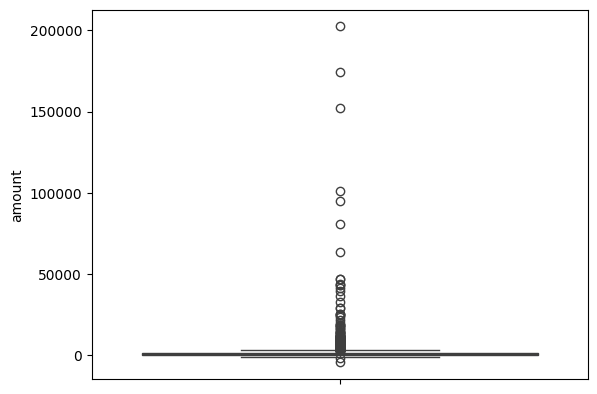

In [99]:
# 1. outlier treatment
sns.boxplot(grouped_df['amount'])

<Axes: ylabel='frequency'>

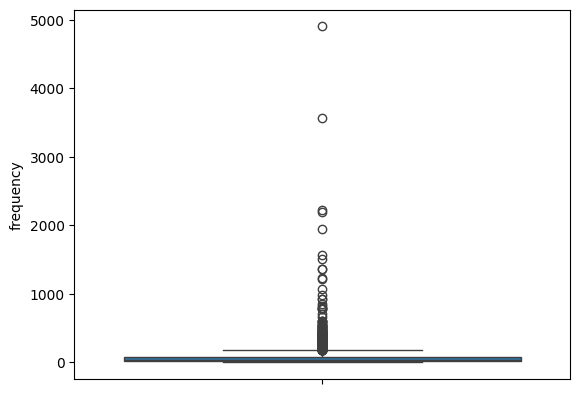

In [100]:
sns.boxplot(grouped_df['frequency'])

<Axes: ylabel='recency'>

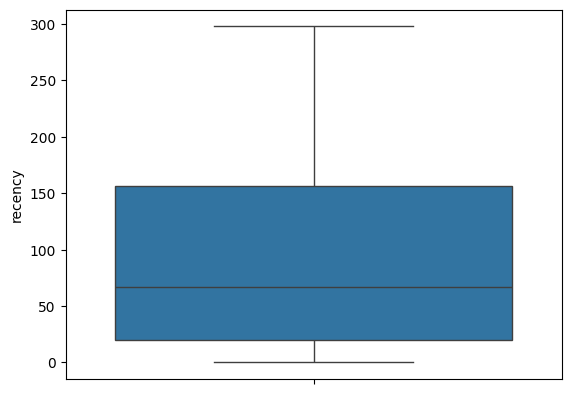

In [101]:
sns.boxplot(grouped_df['recency'])

In [102]:
# two types of outliers:
# - statistical
# - domain specific

In [103]:
# - removeing statistical outliers
Q1=grouped_df.amount.quantile(0.05)
Q3=grouped_df.amount.quantile(0.95)
IQR=Q3-Q1
grouped_df=grouped_df[(grouped_df.amount>=Q1 - 1.5 *IQR) & (grouped_df.amount<=Q3 +1.5 *IQR)]

#outlier treatment for recency

Q1=grouped_df.recency.quantile(0.05)
Q3=grouped_df.recency.quantile(0.95)
IQR=Q3-Q1
grouped_df=grouped_df[(grouped_df.recency>=Q1 - 1.5 *IQR) & (grouped_df.recency<=Q3 +1.5 *IQR)]

#Outliers treatmnent for frequency
Q1=grouped_df.frequency.quantile(0.05)
Q3=grouped_df.frequency.quantile(0.95)
IQR=Q3-Q1
grouped_df=grouped_df[(grouped_df.frequency>=Q1 - 1.5 *IQR) & (grouped_df.frequency<=Q3 +1.5 *IQR)]



In [104]:
# 2. rescaling
rfm_df=grouped_df[['amount','frequency','recency']]

scaler=StandardScaler()
rfm_df_scaled=scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3514, 3)

## Hopkins Statistic Code

In [105]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0

    return H

In [106]:
#First convert the numpy array that you have to a dataframe
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']

In [107]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(rfm_df_scaled)

0.9507800939150148

In [108]:
rfm_df_scaled

,amount,frequency,recency
0,-0.713925,-0.764090,1.806388
1,1.126819,0.776589,-0.484717
2,0.267001,-0.435748,0.906311
3,-0.493368,-0.574662,1.619359
4,-0.075846,0.044135,-1.069183
...,...,...,...
3509,-0.594808,-0.663062,1.245301
3510,-0.660620,-0.700947,0.111438
3511,-0.648787,-0.688319,-0.578232
3512,0.025226,4.855599,-0.893843


# 4. Modelling

In [109]:
#k- means with some arbitary k
kmeans=KMeans(n_clusters=4,max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [110]:
len(kmeans.labels_)

3514

## Finding the Optimal Number of Clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

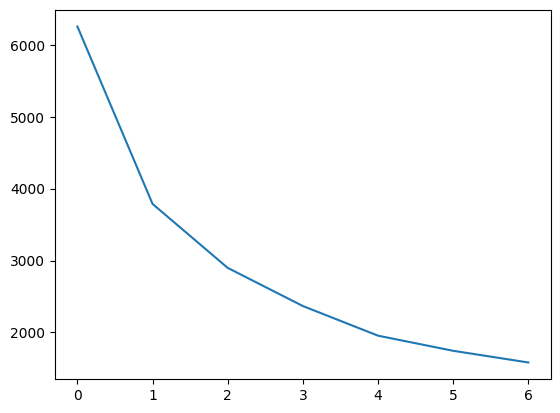

In [111]:
# elbow-curve/SSD
ssd=[]
range_n_clusters=[2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
  kmeans=KMeans(n_clusters=num_clusters,max_iter=50)
  kmeans.fit(rfm_df_scaled )
  ssd.append(kmeans.inertia_)
plt.plot(ssd)

In [112]:
#[2,3,4,5,6,7,8]

In [113]:
# Silhouette Analysis
for num_clusters in range_n_clusters:
  # intialise kmeans
  kmeans=KMeans(n_clusters=num_clusters,max_iter=50)
  kmeans.fit(rfm_df_scaled )
  cluster_labels=kmeans.labels_

  # silhouette score
  silhouette_avg= silhouette_score(rfm_df_scaled,cluster_labels)
  print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters,silhouette_avg))




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.5345681329879132


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=3, the silhouette score is 0.4508611939832533


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.4342240412758366


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.4334233258902986


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.3850331333562001


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=7, the silhouette score is 0.38207590847902306


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.361198560914436


In [114]:
# final model with k=3
kmeans=KMeans(n_clusters=3,max_iter=50)
kmeans.fit(rfm_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

In [115]:
kmeans.labels_

array([1, 0, 1, ..., 0, 2, 1], dtype=int32)

In [116]:
# assign the label
grouped_df['cluster_id']=kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,250,1
1,12347.0,2790.86,124,54,0
2,12348.0,1487.24,28,173,1
3,12350.0,334.40,17,234,1
4,12352.0,967.43,66,4,0


<Axes: xlabel='cluster_id', ylabel='amount'>

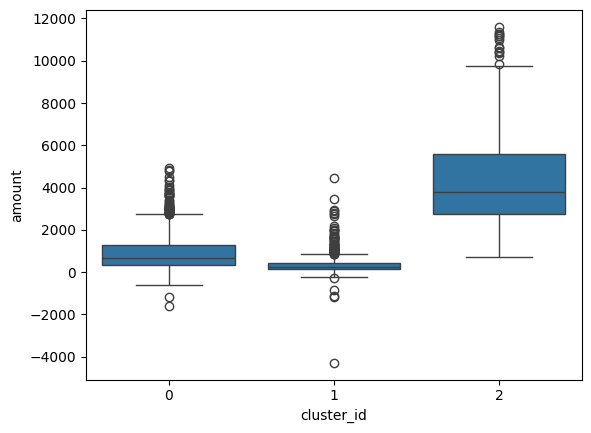

In [117]:
#plot
sns.boxplot(x='cluster_id',y='amount',data=grouped_df)

<Axes: xlabel='cluster_id', ylabel='recency'>

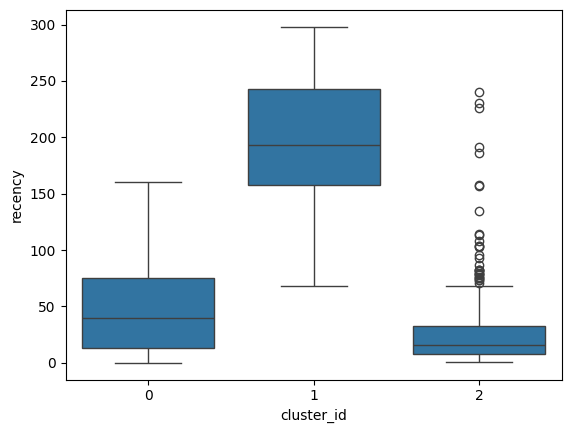

In [118]:
sns.boxplot(x='cluster_id',y='recency',data=grouped_df)

<Axes: xlabel='cluster_id', ylabel='frequency'>

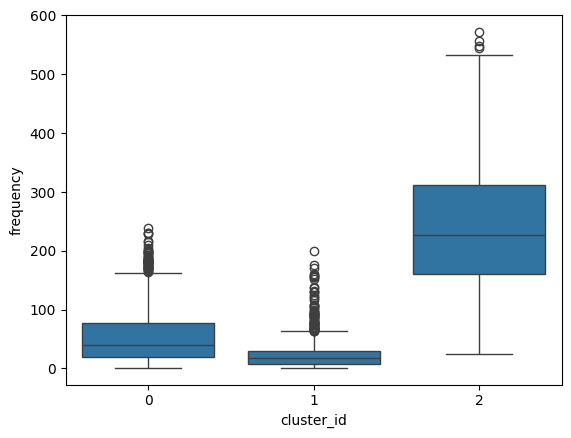

In [119]:
sns.boxplot(x='cluster_id',y='frequency',data=grouped_df)